<a href="https://colab.research.google.com/github/tarabelo/PIAC-2526/blob/main/Algoritmo%20cu%C3%A1ntico%20de%20optimizaci%C3%B3n%20aproximada%20(QAOA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Instalamos qiskit en el notebook
!pip install qiskit[visualization] qiskit_algorithms qiskit_optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 646.5/646.5 kB 19.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.8/327.8 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.1/237.1 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.0 MB/s eta 0:00:00
  Created wheel for docplex: filename=docplex-2.30.251-py3-none-any.whl size=685954 sha256=568c8625f815b0ab7d5d26013f749d0d24ba2012a7db99cd02d5a3eb08d40457
  Stored in directory: /root/.cache/pip/wheels/c1/d9/5c/1d919b1e441eb

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# importing Qiskit
from qiskit import QuantumCircuit

# import basic plot tools
from qiskit.visualization import plot_histogram

# **Algoritmo cuántico de optimización aproximada (QAOA)**

### Contenidos

1. [Discretización de la evolución adiabática (*Trotterization*)](#trotter)
1. [Quantum Approximate Optimization Algorithm (QAOA)](#qaoa)
1. [Programas cuadráticos con restricciones cuadráticas](#cuadraticos)
1. [MAX-CUT como QUBO](#maxcut)

<a name="trotter"></a>
## **Discretización de la evolución adiabática (*Trotterization*)**

Podemos replicar la evolución adiabática en un computador cuántico basado en puertas discretizando la evolución continua del Hamiltoniano.

La evolución temporal de un sistema viene dada por la ecuación de Schrödinger:

$$i\hbar \frac{d}{dt}|\psi(t)\rangle = H(t)|\psi(t)\rangle$$

En general, $H(t)$ depende del tiempo. Pero en un intervalo temporal $[t_i, t_i+\Delta t]$ suficientemente pequeño, podemos considerar $H(t_i)$ constante, verificándose que:

$$|\psi(t_i+\Delta t)\rangle = e^{-iH(t_i)\Delta t}|\psi(t_i)\rangle = U_i|\psi(t_i)\rangle$$

siendo $U_i = e^{-iH(t_i)\Delta t}$ una matriz unitaria.



Si discretizamos la evolución en $p = \frac{T}{\Delta t}$ pasos, podemos escribir:

$$
|\psi(t_1)\rangle = U_0|\psi(t_0)\rangle \\
|\psi(t_2)\rangle = U_1|\psi(t_1)\rangle \\
\cdots \\
|\psi(t_{p})\rangle = U_{p-1}|\psi(t_{p-1})\rangle
$$


De esta forma, el estado final del sistema será:

$$
|\psi(t_{p})\rangle = U_{p-1}U_{p-2}\cdots U_{1}U_{0}|\psi(t_0)\rangle = \left(\prod_{m=p-1}^{0} U_m\right) |\psi(t_0)\rangle =
$$

El Hamiltoniano usado en computación adiabática es:

$$H(t) = A(t)H_0 + B(t)H_c$$

por lo que resulta:

$$
|\psi(T)\rangle = \left(\prod_{m=0}^{p-1} e^{i\Delta t(A'(t_m)H_0 + B'(t_m)H_c)}\right) |\psi(0)\rangle
$$

donde $A'(t_m) = -A(t_{p-1-m})$, $B'(t_m) = -B(t_{p-1-m})$, $|\psi(T)\rangle = |\psi(t_{p})\rangle$ y $|\psi(0)\rangle = |\psi(t_{0})\rangle$

En general, dadas dos matrices $A$ y $B$, la igualdad $e^{A+B} = e^Ae^B$ solo se da si $A$ y $B$ _conmutan_, es decir si $[A,B] = AB-BA = 0$.

Si $\Delta t$ es lo suficientemente pequeño, la formula de Lie-Trotter permite escribir:

$$
e^{i\Delta t(A'(t_m)H_0 + B'(t_m)H_c)} \approx e^{i\Delta tA'(t_m)H_0} e^{i\Delta tB'(t_m)H_c}
$$

Por lo tanto, el estado final del sistema se puede escribir:

$$
|\psi_f\rangle = |\psi(T)\rangle = \left(\prod_{m=0}^{p-1} e^{i\Delta tA'(t_m)H_0} e^{i\Delta tB'(t_m)H_c}\right) |\psi(0)\rangle =
\prod_{m=0}^{p-1} U_0(t_m)U_c(t_m)|\psi_0\rangle
$$

siendo las matrices unitarias:

$$
U_0(t_m) = e^{i\Delta tA'(t_m)H_0}\\
U_c(t_m) = e^{i\Delta tB'(t_m)H_c}
$$

Este procedimiento se denomina _trotterization_ y es la base de algoritmos como el QAOA.




---



---



---




<a name="qaoa"></a>
# **Quantum Approximate Optimization Algorithm (QAOA)**

Algoritmo híbrido basado en la discretización de la evolución adiabática para resolver problemas Ising.

Como ya hemos visto, el estado final del sistema despues de la evolución es:

$$
|\psi_f\rangle = |\psi(T)\rangle = \left(\prod_{m=0}^{p-1} e^{i\Delta tA'(t_m)H_0} e^{i\Delta tB'(t_m)H_c}\right) |\psi(0)\rangle =
\prod_{m=0}^{p-1} U_0(t_m)U_c(t_m)|\psi_0\rangle
$$

siendo las matrices unitarias:

$$
U_0(t_m) = e^{i\Delta tA'(t_m)H_0} = e^{i\beta_mH_0} = U_0(\beta_m)\\
U_c(t_m) = e^{i\Delta tB'(t_m)H_c} = e^{i\gamma_mH_c} = U_c(\gamma_m)
$$
con $m=0,\ldots,p-1$ y $p \ge 1$.

QAOA intenta elegir unos valores de $\beta_m$ y $\gamma_m$ que aproximen el estado $|\psi_f\rangle$ al estado base del Hamiltoniano de coste $H_c$, es decir, que minimizen $\langle\psi_f|H_c|\psi_f\rangle$.

El algoritmo QAOA parte de un Hamiltoniano de coste $H_c$ que define el problema y procede como sigue:

1. Se elige un valor de $p\ge 1$ y dos listas de valores $\boldsymbol{\beta} = (\beta_0,\ldots,\beta_{p-1})$ y $\boldsymbol{\gamma} = (\gamma_0,\ldots,\gamma_{p-1})$
1. Como $H_0$ se suele usar el _mixing Hamiltonian_ y como estado inicial se suele usar la superposición completa
  $$H_0 = -\sum_{i=0}^{n-1} X_i\quad
  |\psi_0\rangle = |+\rangle^{\otimes n}$$
2. La QPU aplica las puertas $U_0(\beta_m)U_c(\gamma_m)$, $m=0,\ldots,p-1$, y se obtiene un nuevo estado $|\psi_p\rangle$
3. En la CPU se usa un algoritmo de optimización para actualizar los parámetros $\boldsymbol{\beta}$ y $\boldsymbol{\gamma}$ intentando minimizar el valor esperado $\langle\psi_p|H_c|\psi_p\rangle$
4. Se vuelve al paso 2 hasta obtener los valores óptimos $\boldsymbol{\beta}^\ast$ y $\boldsymbol{\gamma}^\ast$
5. Usando esos valores, se obtiene el estado que minimiza la solución

El proceso de optimización de los parámetros puede ser un simple gradiente descendente, en el que cada parámetro se actualiza en la dirección que conduzca al mayor descenso del valor esperado, u otros método de optimización más sofisticados.

### Construcción de $U_0(\beta)$ y $U_c(\gamma)$

#### Puertas para $U_0(\beta)$

Si tenemos $n$ cúbits, y dado que las matrices $X$ conmutan tenemos:

$$U_0(\beta) = e^{i\beta H_0} = e^{-i\beta\sum_{i=0}^{n-1} X_i} = \prod_{i=0}^{n-1}e^{-i\beta X_i}$$

Y recordando que la puerta de rotación $R_x(\theta) = e^{-i\theta X/2}$, se tiene:

$$U_0(\beta) = \prod_{i=0}^{n-1} R_x^{(i)}(2\beta)$$

La puerta $R_x^{(i)}$ indica que se aplica una $R_x$ al cúbit $i$ y la identidad al resto $\implies$ el producto equivale a aplicar una puerta $R_x(2\beta)$ a cada uno de los cúbits.

#### Puertas para $U_c(\gamma)$

El Hamiltoniano de coste de un problema Ising es:


$$H_c = -\sum_{i,j = 0}^{n-1} J_{ij}Z_iZ_j -\sum_{i = 0}^{n-1} h_i Z_i$$

siendo $J_{ij}$ y $h_i$ números reales.

Ya que las matricez $Z$ conmutan, podemos escribir

$$
U_c(\gamma) = e^{i\gamma H_c} = e^{-i\gamma(\sum_{i,j = 0}^{n-1} J_{ij}Z_iZ_j +\sum_{i = 0}^{n-1} h_i Z_i)} =
\prod_{i,j = 0}^{n-1}e^{-i\gamma J_{ij}Z_iZ_j}\prod_{i=0}^{n-1}e^{-i\gamma h_i Z_i}
$$

El segundo término se puede implementar con puertas $R_z(\theta) = e^{-i\theta Z/2}$.


Para el primer término, $Z_iZ_j$ representa aplicar una puerta $Z$ a los cúbits $i$ y $j$ y la identidad al resto:

$$
Z_iZ_j = I\otimes\ldots\otimes Z\otimes\ldots\otimes Z \otimes\ldots I = Z_i\otimes Z_j
$$

Y el término $e^{-i\gamma J_{ij}Z_i\otimes Z_j}$ corresponde a una [puerta Ising ZZ](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RZZGate.html#qiskit.circuit.library.RZZGate) entre los cúbits $i$ y $j$:

$$
R_{ZZ}(\theta) = \exp\left(-i\frac{\theta}{2}(Z\otimes Z)\right) =
\exp{\left(-i\frac{\theta}{2}\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & -1 & 0 & 0\\
0 & 0 & -1 & 0\\
0 & 0 & 0 & 1\\
\end{bmatrix} \right)}=
\begin{bmatrix}
e^{-i\theta/2} & 0 & 0 & 0\\
0 & e^{i\theta/2} & 0 & 0\\
0 & 0 & e^{i\theta/2} & 0\\
0 & 0 & 0 & e^{-i\theta/2}\\
\end{bmatrix}
$$

Con lo que queda:

$$
U_c(\gamma) = \prod_{i,j = 0}^{n-1} R_{ZZ}^{(i,j)}(2\gamma J_{ij})\prod_{i=0}^{n-1}R_z^{(i)}(2\gamma h_i)
$$


## Ejemplo 1: Circuito QAOA para un Hamiltoniano Ising

Obtener el circuito QAOA para un paso ($p$=1) del Hamiltoniano Ising:

$$
H_c = 3Z_2Z_0 - Z_2Z_1 + 2Z_0
$$

Necesitamos 3 cúbits, y el estado que queremos conseguir será:

$$
U_0(\beta_1)U_c(\gamma_1)U_0(\beta_0)U_c(\gamma_0) |+\rangle^{\otimes 3}
$$

Con

$$
U_0(\beta_i) = \prod_{i=0}^{2} R_x^{(i)}(2\beta_i) = R_x^{(0)}(2\beta_i)\otimes R_x^{(1)}(2\beta_i)\otimes R_x^{(2)}(2\beta_i)
$$

$$
U_c(\gamma_i) = \prod_{i,j = 0}^{2} R_{ZZ}^{(i,j)}(2\gamma_i J_{ij})\prod_{i=0}^{2}R_z^{(i)}(2\gamma_i h_i) = (R_{ZZ}^{(2,0)}(6\gamma_i)\otimes R_{ZZ}^{(2,1)}(-2\gamma_i))(R_z^{(0)}(4\gamma_i))
$$

El circuito sería:

In [ ]:
from qiskit.circuit import Parameter

n = 3

beta = Parameter('β')
gamma = Parameter('γ')

qc = QuantumCircuit(n)

# Estado superpuesto
qc.h(range(3))

# Puertas U_c
qc.rzz(6*gamma, 2, 0)
qc.rzz(-2*gamma, 2, 1)
qc.rz(4*gamma, 0)

# puertas U_0
for i in range(3):
  qc.rx(2*beta, i)

qc.draw('mpl')

Podemos usar la implementación de QAOA de Qiskit para obtener este mismo circuito

In [ ]:
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

# Expresamos el problema como un operador Hamiltoniano
Hc = SparsePauliOp.from_list([("ZIZ", 3), ("ZZI", -1), ("IIZ", 2)])

# Creamos el ansatz QAOA
ansatz = QAOAAnsatz(Hc, reps=1)

display(ansatz.draw("mpl"))
display(ansatz.decompose(reps=2).draw("mpl"))

La puerta $U_2$ es una rotación de 1 cúbit generalizada, de la forma:

$$
U(\theta, \phi, \lambda) =
\begin{pmatrix}
\cos\left(\frac{θ}{2}\right)          & -e^{i\lambda}\sin\left(\frac{θ}{2}\right) \\
e^{i\phi}\sin\left(\frac{θ}{2}\right) & e^{i(\phi + \lambda)}\cos\left(\frac{θ}{2}\right)
\end{pmatrix}
$$

Así, una puerta $H$ es equivalente a:

$$
H = U\left(\frac{\pi}{2}, 0, \pi\right) = \frac{1}{\sqrt{2}}
\begin{pmatrix}
1          & -e^{i\pi} \\
e^{i0} & e^{i(0 + \pi)}
\end{pmatrix} =
\frac{1}{\sqrt{2}}\begin{pmatrix}
1          & 1 \\
1 & -1
\end{pmatrix}
$$

## Ejemplo 2: Encontrar el estado que minimiza el Hamiltoniano anterior

#### a) Resolverlo por fuerza bruta

In [ ]:
from qiskit.quantum_info import Statevector

# Creamos una lista con todos los estados base para n cúbits
estados = [Statevector.from_int(i, dims=2**n) for i in range(2**n)]

# Obtenemos los valores esperados para todos los posibles estados
evs = {}
for i in range(2**n):
  evs[np.binary_repr(i,n)] = estados[i].expectation_value(Hc).real

# Obtenemos el estado con menor valor esperado
min_state = min(evs, key=evs.get)
print("Estado que minimiza Hc = {}".format(min_state))
print("Valor esperado <{}|Hc|{}> = {}".format(min_state, min_state, evs[min_state]))

#### b) Resolverlo con QAOA

Usar el algoritmo QAOA con el circuito anterior para encontrar el estado solución del problema.

Usaremos un *Estimator*  para encontrar el valor esperado del Hamiltoniano de coste.

El uso de cualquier versión de Estimator es similar:

- Se crea un objeto de la clase Estimator que se vaya a usar (que puede incluir parámetros)
- Se llama al método run con una lista de PUBS (Primitive Unified Blocs)

El PUB de un Estimator es una lista o tupla de dos a cuatro elementos:

- Un circuito cuántico (que puede ser parametrizado)
- Uno o más observables (Pauli, SparsePauliOp, string)
- Una colección de parámetros para el circuito (opcional)
- Opcionalmente, la precisión de la estimación (opcional)

Cada PUB (circuito, observables, valores de parámetros, precisión) de la lista que se pasa al método run, produce su propio resultado. Así, se pueden ejecutar diferentes combinaciones con una sola llamada al método run().

In [ ]:
# @title Definimos una función que devuelve el valor esperado del hamiltoniano de coste al aplicar el circuito
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

  # Creamos el PUB(circuito, observable, parámetros=)
  pub = (ansatz, hamiltonian, params)

  # Al método run hay que pasarle una lista de PUBS aunque sea de un solo elemento
  job = estimator.run([pub])

  # Job devuelve un array de resultados, nos quedamos con el primero
  results = job.result()[0]

  # evs: lista de ExpectedValues (uno solo en este caso)
  cost = results.data.evs

  # objetive_func_cvals es una lista global en la vamos metiendo todos los valores que vamos obteniendo para ver su evolución
  objective_func_vals.append(cost)

  return cost

Usamos una función de miminización de ScyPy (scipy.optimize.minimize).

In [ ]:
#@title Resolvemos usando el StateVectorEstimator de Qiskit y Scipy
from qiskit.primitives import StatevectorEstimator
from scipy.optimize import minimize

# Parámetros iniciales
initial_gamma = np.pi
initial_beta = np.pi / 2

init_params = [initial_beta, initial_gamma]

# Creamos el objeto estimator
estimador = StatevectorEstimator()

# Llamamos a la funcion para obtener el valor esperado
objective_func_vals = []
result = minimize(
        fun = cost_func_estimator,
        x0 = init_params,
        args=(ansatz, Hc, estimador),
        method="COBYLA",
        tol=1e-2
    )
print(result)

In [ ]:
print("Parametros que obtienen el mínimo: β_m = {}, γ_m = {}".format(result.x[0], result.x[1]))

In [ ]:
# Vemos la evolución del minimizador
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

Recreamos el circuito con los parámetros obtenidos y le añadimos medidas:

In [ ]:
circuito_final = ansatz.assign_parameters(result.x)

# Añadimos las medidas
circuito_final.measure_all()
circuito_final.decompose(reps=2).draw('mpl')

Ejecutamos el circuito y usamos un sampler para obtener el estado más frecuente.

In [ ]:
# Usamos el sampler base de Qiskit (basado en Statevector)
from qiskit.primitives import StatevectorSampler

def circuit_sampler(circuit, sampler, shots=10000):

  pub = (circuit,)
  job = sampler.run([pub])

  # counts_int: Diccionario con claves=estados (binario), valor=ocurrencias
  counts = job.result()[0].data.meas.get_counts()

  # Probabilidades de cada estado (como diccionario Python)
  # Diccionario con claves=estados (binario), valor=probabilidad
  final_distribution = {key: val / shots for key, val in counts.items()}

  # Estado con mayor probabilidad
  min_state = max(final_distribution, key=final_distribution.get)

  return(min_state, final_distribution)


In [ ]:
# Lo ejecutamos con un StatevectorSampler
sampler = StatevectorSampler()
min_state, data_distribution = circuit_sampler(circuito_final, sampler)

# Valor esperado del Hc en ese estado
ev = Statevector.from_label(min_state).expectation_value(Hc).real

print("Estado que minimiza Hc = {}".format(min_state))
print("Valor esperado <{}|Hc|{}> = {}\n".format(min_state, min_state, ev))

In [ ]:
# Vemos la distribución de las muestras
from qiskit.visualization import plot_histogram
display(plot_histogram(data_distribution))

#### c) Resolverlo usando la implementación de QAOA de Qiskit

Usamos la implementación de [QAOA](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.QAOA.html) del paquete [qiskit_algorithms](https://qiskit-community.github.io/qiskit-algorithms/apidocs/qiskit_algorithms.html).

In [ ]:
from qiskit_algorithms import QAOA
from qiskit.primitives import StatevectorSampler
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 10598

# Parámetros iniciales
initial_gamma = np.pi
initial_beta = np.pi / 2

init_params = [initial_beta, initial_gamma]

# Utilizo el mismo optimizador que antes
optimizer = COBYLA()

# Tambien uso el mismo sampler
sampler = StatevectorSampler()

# Defino el algoritmo
qaoa = QAOA(sampler=sampler, optimizer=optimizer, initial_point=init_params)

# Obtengo el mínimo autovalor del Hamiltoniano
result = qaoa.compute_minimum_eigenvalue(Hc)

min_state = result.best_measurement['bitstring']
ev = result.best_measurement['value']
print("Estado que minimiza Hc = {}".format(min_state))
print("Valor esperado <{}|Hc|{}> = {}\n".format(min_state, min_state, ev.real))

El circuito que utilizó:

In [ ]:
result.optimal_circuit.decompose(reps=2).draw('mpl')

---


---


## **Ejercicio 6**:


En el ejercicio 2, habíamos expresado como QUBO el problema de la suma de subconjuntos para $S=\{-3, 2, -2, 5, 1\}$ y $T=4$. Resuélvelo usando QAOA:

a) Creando el circuito como un QAOAAnsatz y utilizando la función de minimización de Scipy

b) Usando la implementación de QAOA de qiskit_algorithms




---



---



<a name="cuadraticos"></a>

## **Programas cuadráticos con restricciones cuadráticas**

La librería de optimización de Qiskit incorpora una librería para resolver problemas QCQP con variables binarias y/o enteras.

**Ejemplo**

Minimiza $y=10x_0+20x_1+30 x_2 +  4 x_0x_1 + 2 x_0x_2 + 6 x_1x_2 + 4 x_1^2  + 2 x_2^2$

con las siguientes restricciones:

  - $x_0\in\{0,1\}$
  - $x_1, x_2 \in \mathbb{Z}, -1\le x_1 \le 1, -2\le x_2 \le 3$

Podemos expresar el problema de la siguiente forma:ç

Se puede escribir como:
$$
\begin{align}
\text{minimizar} &&x^T Q x + c^T x &&\\
&& && \\
\text{sujeto a} &&x_0\in\{0,1\}, x_1, x_2 \in \mathbb{Z}  &&\\
&& -1\le x_1 \le 1 \\
&& -2\le x_2 \le 3 \\
\end{align}
$$

Se puede probar fácilmente que $Q$ y $c$ en este ejemplo valen:

$$
\begin{aligned}
Q  &= \begin{bmatrix}0 & 1 & 2 \\ 3 & 4 & 5 \\ 0 & 1 & 2 \end{bmatrix}\\[10pt]
c^T &= \begin{bmatrix}10&20&30\end{bmatrix}
\end{aligned}
$$

In [ ]:
from qiskit_optimization import QuadraticProgram

# Definimos el problema cuadrático
qprog = QuadraticProgram('Ejemplo')

# Fijamos el tipo de las variables y sus restricciones
qprog.binary_var(name = 'x_0')
qprog.integer_var(name = 'x_1', lowerbound = -1, upperbound = 1)
qprog.integer_var(name = 'x_2', lowerbound = -2, upperbound = 3)

# Matriz Q y vector c
Q = [[0,1,2],[3,4,5],[0,1,2]]
c = [10,20,30]

# Exprersamos el problema como una minimización
qprog.minimize(quadratic = Q, linear = c)

print(qprog.prettyprint())

Este problema puede ser resuelto mediante QAOA usando el método [`MinimumEigenOptimizer`](https://qiskit-community.github.io/qiskit-optimization/stubs/qiskit_optimization.algorithms.MinimumEigenOptimizer.html) que se encarga de convertir el programa cuadrático a un circuito y de realizar la optimización.

A este método hay que pasarle un objeto de una clase que implemente la interfaz [`MinimumEigenSolver`](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.MinimumEigensolver.html), como puede ser un objeto [`VQE`](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.VQE.html) o [`QAOA`](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.QAOA.html).

**NOTA**: Este código tarda mucho en ejecutarse (más de 1 hora).

In [ ]:
%%time
from qiskit_algorithms import QAOA
from qiskit.primitives import StatevectorSampler
from qiskit_algorithms.optimizers import ADAM
from qiskit_optimization.algorithms import MinimumEigenOptimizer

sampler = StatevectorSampler()

optimizer = ADAM()

qaoa = QAOA(sampler=sampler, optimizer=optimizer, initial_point=[0.0, 0.0])

# Creamos el optimizador
eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver = qaoa)

# Usamos ese optimizador sobre el problema anterior
result = eigen_optimizer.solve(qprog)

print(result)

Podemos comprobar que el resultado es correcto usando un minimizador clásico.

In [ ]:
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver

np_solver = NumPyMinimumEigensolver()
np_optimizer = MinimumEigenOptimizer(min_eigen_solver = np_solver)

result = np_optimizer.solve(qprog)
print(result)



---



---



---



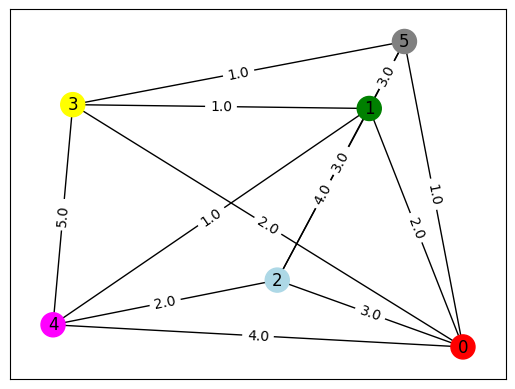

In [4]:
import networkx as nx  # Librería para manejar grafos

# Ejemplo de grafo con 6 nodos
nnodes = 6
G = nx.Graph()
# Añade nodos y aristas
G.add_nodes_from(np.arange(0,nnodes,1))
edges = [(0,1,2.0),(0,2,3.0),(0,3,2.0),(0,4,4.0),(0,5,1.0),(1,2,4.0),(1,3,1.0),
         (1,4,1.0),(1,5,3.0),(2,4,2.0),(2,5,3.0),(3,4,5.0),(3,5,1.0)]
G.add_weighted_edges_from(edges)

# Mostramos el grafo
layout = nx.random_layout(G,seed=10)
colors = ['red', 'green', 'lightblue', 'yellow', 'magenta', 'gray']
nx.draw_networkx(G, layout, node_color=colors)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels);

In [5]:
print("Matriz de adyacencias del grafo")
print(nx.adjacency_matrix(G).toarray())

Matriz de adyacencias del grafo
[[0. 2. 3. 2. 4. 1.]
 [2. 0. 4. 1. 1. 3.]
 [3. 4. 0. 0. 2. 3.]
 [2. 1. 0. 0. 5. 1.]
 [4. 1. 2. 5. 0. 0.]
 [1. 3. 3. 1. 0. 0.]]


Vamos a obtener por fuerza bruta el coste de todos los cortes.

In [6]:
# Función de coste de Maxcut
def maxcut_coste(graph, bitstring):
    """
    Computa la función de coste del Maxcut para un grafo y un corte representado por un string de bits
    Args:
        graph: El grafo networkx
        bitstring: str
                   Un string con valores 0 o 1 especificando un corte en el grafo
    Returns:
        coste: float
               El coste del corte
    """
    # Matriz de adyacencias del grafo
    weight_matrix = nx.adjacency_matrix(graph).toarray()
    coste = 0
    for i, j in graph.edges():
        # Si los vértices están en conjuntos distintos suma el peso de la arista
        if bitstring[i] != bitstring[j]:
            coste += weight_matrix[i,j]

    return coste

In [7]:
# Obtenemos por fuerza bruta los valores de todos los posibles cortes
num_vars = G.number_of_nodes()

#Creamos una lista de bitstrings con todos los posibles cortes
bitstrings = ['{:b}'.format(i).rjust(num_vars, '0') for i in range(2**num_vars)]
print(bitstrings)

costes = list()
for bitstring in bitstrings:
    costes.append(maxcut_coste(G, bitstring))
print(costes)

# Ordenamos los costes y los bitstrings en orden creciente de coste
costes, bitstrings = zip(*sorted(zip(costes, bitstrings)))

['000000', '000001', '000010', '000011', '000100', '000101', '000110', '000111', '001000', '001001', '001010', '001011', '001100', '001101', '001110', '001111', '010000', '010001', '010010', '010011', '010100', '010101', '010110', '010111', '011000', '011001', '011010', '011011', '011100', '011101', '011110', '011111', '100000', '100001', '100010', '100011', '100100', '100101', '100110', '100111', '101000', '101001', '101010', '101011', '101100', '101101', '101110', '101111', '110000', '110001', '110010', '110011', '110100', '110101', '110110', '110111', '111000', '111001', '111010', '111011', '111100', '111101', '111110', '111111']
[0, np.float64(8.0), np.float64(12.0), np.float64(20.0), np.float64(9.0), np.float64(15.0), np.float64(11.0), np.float64(17.0), np.float64(12.0), np.float64(14.0), np.float64(20.0), np.float64(22.0), np.float64(21.0), np.float64(21.0), np.float64(19.0), np.float64(19.0), np.float64(11.0), np.float64(13.0), np.float64(21.0), np.float64(23.0), np.float64(18.0

In [8]:
print("Corte de mayor coste = ",bitstrings[len(bitstrings)-1], ", coste = ", costes[len(bitstrings)-1])


Corte de mayor coste =  101100 , coste =  23.0


In [9]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# Muestra una gráfica con los valores
bar_plot = go.Bar(x = bitstrings, y = costes, marker=dict(color=costes, colorscale = 'plasma', colorbar=dict(title='Cut Value')))
fig = go.Figure(data=bar_plot, layout = dict(xaxis=dict(type = 'category'), width = 1500, height = 600))
fig.show()



---



Resolvemos el problema de optimización con QAOA

In [11]:
from qiskit_optimization import QuadraticProgram

# Nº de nodos del grafo y matriz de pesos
nnodes = len(G.nodes())
weight_matrix = nx.adjacency_matrix(G).toarray()

# Matriz Q
Q = -weight_matrix

# Vector c
c = np.zeros(nnodes)
for i in range(nnodes):
    for j in range(nnodes):
        c[i] += weight_matrix[i,j]

# Defino el problema
qubo_maxcut = QuadraticProgram('Maxcut como problema cuadrático')

# Variables binarias del problema
for i in range(nnodes):
    nombre = 'x_'+str(i)
    qubo_maxcut.binary_var(name = nombre)

# Especificalo como un problema de maximizacion e imprimelo
qubo_maxcut.maximize(quadratic = Q, linear = c)
print(qubo_maxcut.prettyprint())

Problem name: Maxcut como problema cuadrático

Maximize
  -4*x_0*x_1 - 6*x_0*x_2 - 4*x_0*x_3 - 8*x_0*x_4 - 2*x_0*x_5 - 8*x_1*x_2
  - 2*x_1*x_3 - 2*x_1*x_4 - 6*x_1*x_5 - 4*x_2*x_4 - 6*x_2*x_5 - 10*x_3*x_4
  - 2*x_3*x_5 + 12*x_0 + 11*x_1 + 12*x_2 + 9*x_3 + 12*x_4 + 8*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5



In [12]:
%%time
from qiskit_algorithms import QAOA
from qiskit.primitives import StatevectorSampler
from qiskit_algorithms.optimizers import ADAM
from qiskit_optimization.algorithms import MinimumEigenOptimizer

sampler = StatevectorSampler()

optimizer = ADAM()

qaoa = QAOA(sampler=sampler, optimizer=optimizer, initial_point=[0.0, 0.0])

# Creamos el optimizador
eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver = qaoa)

# Usamos el optimizador anterior sobre este problema
result = eigen_optimizer.solve(qubo_maxcut)
print(result)

/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning:

splu converted its input to CSC format

/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning:

spsolve is more efficient when sparse b is in the CSC matrix format



fval=23.0, x_0=1.0, x_1=0.0, x_2=1.0, x_3=1.0, x_4=0.0, x_5=0.0, status=SUCCESS
CPU times: user 1h 13min 42s, sys: 34 s, total: 1h 14min 16s
Wall time: 42min 31s


#### Referencias

  - Farhi, E., Goldstone, J., & Gutmann, S. (2014). A quantum approximate optimization algorithm. arXiv preprint [arXiv:1411.4028](https://arxiv.org/abs/1411.4028)
  - Ejemplo definiendo el circuito: https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm



---



---



---

